# Where to sell products
## Author: Luis Eduardo Ferro Diez, <a href="mailto:luis.ferro1@correo.icesi.edu.co">luis.ferro1@correo.icesi.edu.co</a>

This notebook contains the main work and contribution of the project, exploiting geo tagged social network data to predict where to sell specific products depending on the content being posted by the users.


In [1]:
import pandas as pd

base_path = "/media/ohtar10/Adder-Storage/datasets/twitter"
tweets_path = base_path + "/pruned/tweets/"
tweets = pd.read_parquet(tweets_path, engine="pyarrow")
tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_name,place_full_name,country,country_code,place_type,place_url,year,month,day,hour
0,384905527706542080,I'm at Mahatma Gading Nasional Plus School (Ja...,id,0.0,0.0,0.0,234670148,richardgbt,306.0,280.0,...,Pulo Gadung,"Pulo Gadung, Jakarta Timur",Indonesia,ID,city,https://api.twitter.com/1.1/geo/id/8496c55fb5d...,2013,10,1,0
1,384905536107319296,"But I honestly don't give a fuck, because I di...",en,0.0,0.0,0.0,28929946,rachelzerber,344.0,124.0,...,Arizona,"Arizona, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/a612c69b44b...,2013,10,1,0
2,384905548690653184,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,de,0.0,0.0,0.0,162780830,BixTweet057,3.0,0.0,...,Montréal,"Montréal, Québec",Canada,CA,city,https://api.twitter.com/1.1/geo/id/378a442883b...,2013,10,1,0
3,384905548690255872,Ask te odio pero a la ves te amo :),es,0.0,0.0,0.0,38001073,bernageek,728.0,469.0,...,Pachuca de Soto,"Pachuca de Soto, Hidalgo",México,MX,city,https://api.twitter.com/1.1/geo/id/8747ffc9cc7...,2013,10,1,0
4,384905552855592961,"""@ThelIluminati: The #governmentshutdown but t...",en,0.0,0.0,0.0,297722693,wifi_whor3,372.0,708.0,...,Pasadena,"Pasadena, TX",United States,US,city,https://api.twitter.com/1.1/geo/id/3e82edc94d5...,2013,10,1,0


In [2]:
tweets.columns

Index(['id', 'tweet', 'lang', 'favorite_count', 'retweet_count', 'is_retweet',
       'user_id', 'user_name', 'user_followers_count', 'user_following_count',
       'user_location', 'created_timestamp', 'hashtags', 'user_mentions',
       'user_id_mentions', 'expanded_urls', 'location_geometry',
       'place_geometry', 'place_id', 'place_name', 'place_full_name',
       'country', 'country_code', 'place_type', 'place_url', 'year', 'month',
       'day', 'hour'],
      dtype='object')

### TODO Filter by language

We are interested only in tweets written in english language, primarily because that is the language in which the product reviews are written hence to preserve the semantic relation, only english tweets will be taken into account. However, the amount of tweets without a language can significant, hence we need to predict the language of the tweets. We already pre-trained an ANN for this purpose.



Let's visualize the tweets on a map.

First, we will create a geopandas dataframe from the original data.

In [3]:
from shapely import wkt
import geopandas as gpd

# Some tweets might have appear without place or location geometry
tweets = tweets[(tweets.place_geometry.notnull()) | (tweets.location_geometry.notnull())]

def parse_geometry(geom):
    if geom:
        return wkt.loads(geom)
    else:
        return None

tweets.location_geometry = tweets.location_geometry.apply(parse_geometry)
tweets.place_geometry = tweets.place_geometry.apply(parse_geometry)

# Let's work first with the location geometry first
geo_tweets = gpd.GeoDataFrame(tweets, geometry='location_geometry')
geo_tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_name,place_full_name,country,country_code,place_type,place_url,year,month,day,hour
0,384905527706542080,I'm at Mahatma Gading Nasional Plus School (Ja...,id,0.0,0.0,0.0,234670148,richardgbt,306.0,280.0,...,Pulo Gadung,"Pulo Gadung, Jakarta Timur",Indonesia,ID,city,https://api.twitter.com/1.1/geo/id/8496c55fb5d...,2013,10,1,0
1,384905536107319296,"But I honestly don't give a fuck, because I di...",en,0.0,0.0,0.0,28929946,rachelzerber,344.0,124.0,...,Arizona,"Arizona, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/a612c69b44b...,2013,10,1,0
2,384905548690653184,Metcalfe / Sainte-Catherine: 01:00 - Disponibl...,de,0.0,0.0,0.0,162780830,BixTweet057,3.0,0.0,...,Montréal,"Montréal, Québec",Canada,CA,city,https://api.twitter.com/1.1/geo/id/378a442883b...,2013,10,1,0
3,384905548690255872,Ask te odio pero a la ves te amo :),es,0.0,0.0,0.0,38001073,bernageek,728.0,469.0,...,Pachuca de Soto,"Pachuca de Soto, Hidalgo",México,MX,city,https://api.twitter.com/1.1/geo/id/8747ffc9cc7...,2013,10,1,0
4,384905552855592961,"""@ThelIluminati: The #governmentshutdown but t...",en,0.0,0.0,0.0,297722693,wifi_whor3,372.0,708.0,...,Pasadena,"Pasadena, TX",United States,US,city,https://api.twitter.com/1.1/geo/id/3e82edc94d5...,2013,10,1,0


## Visualize the tweets in the map
Now let's visualize this information on a map

In [5]:
import ipyleaflet as ipy

gtdf = geo_tweets.iloc[:200][["id", "location_geometry"]]
geo_data = ipy.GeoData(geo_dataframe=gtdf,
                       style={'properties': {'marker-size': 'small'}},
                       icon="https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Location_dot_blue.svg/64px-Location_dot_blue.svg.png",
                       name="Geo Tweets")

tweets_map = ipy.Map(center=(52.3, 8.0), 
            zoom=2,
            scroll_wheel_zoom=True,
            basemap=ipy.basemaps.Esri.WorldTopoMap)

tweets_map.add_layer(geo_data)
tweets_map.add_control(ipy.LayersControl())
tweets_map

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

## As Heatmap
With heatmaps visualization we can easily observe where are the highest concentration of tweets. This is useful to further select an area of interest.

In [6]:
import ipyleaflet as ipy

def display_heatmap(center, zoom, geom, radius=20, blur=10):    
    point_list = [(p.y, p.x) for p in geom.values if p]
    heatmap = ipy.Heatmap(
        locations = point_list,
        radius=radius,
        blur=blur
    )

    m = ipy.Map(center=center,
              zoom=zoom,
              scroll_wheel_zoom=True,
              basemap=ipy.basemaps.Esri.WorldTopoMap)

    m.add_layer(heatmap)
    return m

w_heatmap = display_heatmap(center=(52.3, 8.0),
               zoom=3,
               geom=geo_tweets["location_geometry"])
w_heatmap

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

It is expected to have North America as one of areas with highest twitter activity.

Let's work with North America first, let's observe in numbers how much tweets we have there.

In [7]:
geo_tweets.place_type.unique()

array(['city', 'admin', 'country', 'neighborhood', 'poi'], dtype=object)

First, we observe the place types we have, let's filter by all the tweets within the US.

In [8]:
tweet_count_by_country = geo_tweets.groupby('country').count()

In [9]:
us_tweet_count = tweet_count_by_country.loc['United States']['tweet']
print(f'Total tweets in the US {us_tweet_count}')

Total tweets in the US 618226


In [10]:
us_tweets = geo_tweets[geo_tweets.country == 'United States']
us_tweets.head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_name,place_full_name,country,country_code,place_type,place_url,year,month,day,hour
1,384905536107319296,"But I honestly don't give a fuck, because I di...",en,0.0,0.0,0.0,28929946,rachelzerber,344.0,124.0,...,Arizona,"Arizona, US",United States,US,admin,https://api.twitter.com/1.1/geo/id/a612c69b44b...,2013,10,1,0
4,384905552855592961,"""@ThelIluminati: The #governmentshutdown but t...",en,0.0,0.0,0.0,297722693,wifi_whor3,372.0,708.0,...,Pasadena,"Pasadena, TX",United States,US,city,https://api.twitter.com/1.1/geo/id/3e82edc94d5...,2013,10,1,0
5,384905569653358592,Magic mike on TV? I think yes,en,0.0,0.0,0.0,1124221580,Gabers22,35.0,88.0,...,Anaheim,"Anaheim, CA",United States,US,city,https://api.twitter.com/1.1/geo/id/0c2e6999105...,2013,10,1,0
6,384905586438971392,@emilyparkhurst Yes! Thank you!,en,0.0,0.0,0.0,17953151,WhitneyT,1555.0,1202.0,...,Edmonds,"Edmonds, WA",United States,US,city,https://api.twitter.com/1.1/geo/id/eaa5a4f94dc...,2013,10,1,0
7,384905586435190785,@AndrewJerdonek don't forget about meeeee,en,0.0,0.0,0.0,330831579,AustinRich61,221.0,319.0,...,New Albany,"New Albany, IN",United States,US,city,https://api.twitter.com/1.1/geo/id/ec5febdaca1...,2013,10,1,0


In [11]:
us_heatmap = display_heatmap(center=(39, -97),
               zoom=4,
               geom=us_tweets['location_geometry'])
us_heatmap

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

### Find clusters in the US

The idea is to detect clusters among these geo-tagged tweets, then perform a LDA topic detection and finally measure the relevance of each topic against a product or service to characterize each geographic cluster as per the product relationship.

For this, we need to first compute the clusters. We are going to use DBSCAN since one of it's properties is that it does not depend on a central tendency measurement and it is not constrained by the shape of the clusters.

Since we just want to detect clusters based on the geographic position, we just need the geometry.

#### Simplyfying
For simplicity, we prefer to apply the clustering on a particular state, let's explore them.

In [12]:
us_tweets_place_count = us_tweets.groupby('place_name').count()
us_tweets_place_count.sort_values('tweet', ascending=False).head()

,id,tweet,lang,favorite_count,retweet_count,is_retweet,user_id,user_name,user_followers_count,user_following_count,...,place_id,place_full_name,country,country_code,place_type,place_url,year,month,day,hour
place_name,,,,,,,,,,,,,,,,,,,,,
Los Angeles,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780,...,10780,10780,10780,10780,10780,10780,10780,10780,10780,10780
New York,8297,8297,8297,8297,8297,8297,8297,8297,8297,8297,...,8297,8297,8297,8297,8297,8297,8297,8297,8297,8297
Texas,7656,7656,7656,7656,7656,7656,7656,7656,7656,7656,...,7656,7656,7656,7656,7656,7656,7656,7656,7656,7656
Manhattan,7449,7449,7449,7449,7449,7449,7449,7449,7449,7449,...,7449,7449,7449,7449,7449,7449,7449,7449,7449,7449
Georgia,6816,6816,6816,6816,6816,6816,6816,6816,6816,6816,...,6816,6816,6816,6816,6816,6816,6816,6816,6816,6816


We can observe that most tweets comes from the city of Los Ageles, let's continue working with this location.

In [13]:
la_tweets = us_tweets[us_tweets.place_name == 'Los Angeles']
la_heatmap = display_heatmap(center=(34, -118),
               zoom=10,
               geom=la_tweets['location_geometry'])
la_heatmap

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

In [14]:
from ipywidgets.embed import embed_minimal_html
embed_minimal_html('la_tweets.html', views=[la_heatmap], title='LA Tweets heatmap')

In [15]:
import numpy as np

points = la_tweets[la_tweets.location_geometry.notnull()].location_geometry.apply(lambda p: [p.x, p.y])
points = np.array(points.values.tolist())
points.shape

(9025, 2)

In [16]:
import random

def get_sample_indices(max_value, n_samples=10, random_seed=42):
    random.seed(random_seed)
    indices = random.sample(range(max_value), n_samples)
    return indices


In [17]:
sample_indices = get_sample_indices(points.shape[0], n_samples=points.shape[0])
quick_train_points = points[sample_indices]

### Select the best Hyperparameters for DBSCAN

Resource: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

The most important parameters in DBSCAN are:
* Epsilon (eps): The maxmun distance between points to be considered neighbors.
* min_samples: The minimum number of instances for them to be considered as a cluster.

We need to validate what are the best values for these properties. For this, we need to train the model several times with different option values and track the results to finally observe what is the best combination.

First, let's visualize the points as they are to have an idea of the possible value for $k$ i.e., the number of neighbors for the cluster.

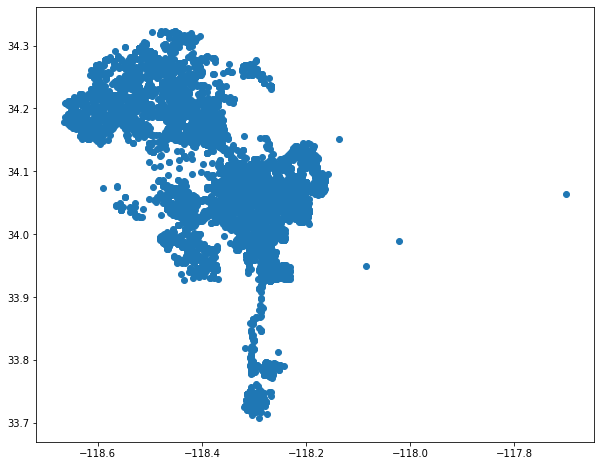

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(quick_train_points[:, 0], quick_train_points[:, 1])
plt.show()

We can observe small groups of points, though they are do not seem very well defined. We should not pick a value too high for $k$, hence let's continue with $k=5$.

Now, let's evaluate what is the best value for $eps$.

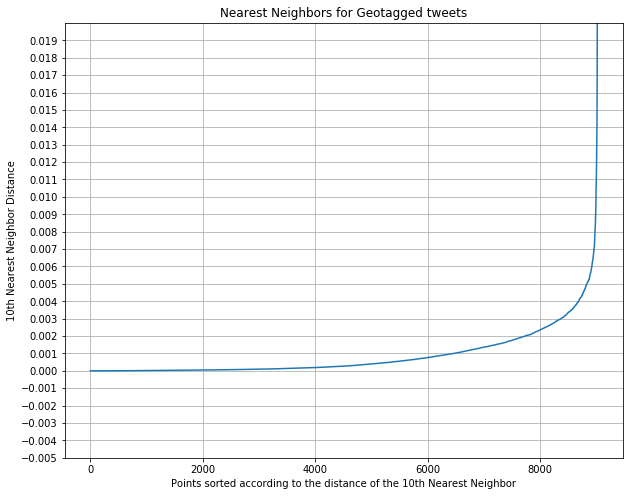

In [17]:
from sklearn.neighbors import NearestNeighbors

def plot_nearest_neighbors(X, n_neighbors=2):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(quick_train_points)
    distances, indices = nbrs.kneighbors(quick_train_points)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    plt.figure(figsize=(10, 8))
    plt.grid()
    axes = plt.gca()
    axes.set_ylim([-0.005, 0.02])
    plt.yticks(np.arange(-0.005, 0.02, 0.001))
    plt.title("Nearest Neighbors for Geotagged tweets")
    plt.ylabel(f"{n_neighbors}th Nearest Neighbor Distance")
    plt.xlabel(f"Points sorted according to the distance of the {n_neighbors}th Nearest Neighbor")
    plt.plot(distances)
    plt.show()

plot_nearest_neighbors(quick_train_points, 10)

According to the Nearest Neighbor analysis, for `k=10` the best distance would be $0.005$. Let's use these values as eps.

#### Warning
The cell below takes quite some time to execute even in powerful machines, execute it wisely!!

In [23]:
%%time
from sklearn.cluster import OPTICS
from sklearn import metrics

optics = OPTICS(cluster_method="dbscan",
                eps=0.003,
                min_samples=10,
                metric="minkowski",
                n_jobs=-1).fit(quick_train_points)

CPU times: user 1min 47s, sys: 33.8 s, total: 2min 21s
Wall time: 16min 32s


Let's save and load back the model so we always have a reference of it without training it again.

In [26]:
import pickle

model_path = '../../models/sklearn/la_dbscan.sav'
with open(model_path, 'wb') as model_file:
    pickle.dump(optics, model_file)

In [27]:
import pickle

model_path = '../../models/sklearn/la_dbscan.sav'
with open(model_path, 'rb') as model_file:
    la_clusters = pickle.load(model_file)

Let's calculate some metrics...

In [28]:
from sklearn import metrics

labels = la_clusters.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('#' * 20)
print('Including the noise')
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(quick_train_points, labels))
print('#' * 20)
print('Excluding the noise')
qpoints, qlabels = list(zip(*[(p, l) for p, l in zip(quick_train_points, labels) if l != -1]))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(qpoints, qlabels))

####################
Including the noise
Estimated number of clusters: 164
Estimated number of noise points: 4864
Silhouette Coefficient: -0.269
####################
Excluding the noise
Silhouette Coefficient: 0.497


In [29]:
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def display_clusters_on_map(tweets, clusters):
    tweets["cluster"] = clusters
    n_clusters = np.unique(clusters).shape[0]
    colormap = cycle(plt.cm.rainbow(np.linspace(0, 1, n_clusters)))
    colors = {k: matplotlib.colors.to_hex(next(colormap)) for k in range(n_clusters)}
    colors[-1] = '#000000'
    def create_marker(row):
        lat_lon = (row["location_geometry"].y, row["location_geometry"].x)
        cluster = row["cluster"]
        color = colors[cluster]
        return ipy.CircleMarker(location=lat_lon,
                               draggable=False,
                               fill_color=color,
                               fill_opacity=0.8 if cluster != -1 else 0.5,
                               radius=3,
                               stroke=False)
    
    markers = tweets.apply(create_marker, axis=1)
    layer_group = ipy.LayerGroup(layers=tuple(markers.values))
    m = ipy.Map(center=(34, -118), 
                zoom=10,
                scroll_wheel_zoom=True,
                basemap=ipy.basemaps.Esri.WorldTopoMap)
    m.add_layer(layer_group)
    return m

la_tweets_with_geom = la_tweets[la_tweets.location_geometry.notnull()]
la_cl_map = display_clusters_on_map(la_tweets_with_geom.iloc[sample_indices],
                        la_clusters.labels_)
la_cl_map

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

Now, let's visualize the clusters in the map.

In [30]:
embed_minimal_html('clusters.html', views=[la_cl_map], title='Tweets Clusters')

## Tweets topic modeling
Now, we need to perform topic modeling on each cluster. Since every single tweet is too short in content, the aggregated tweets of a cluster will be used as text corpora for the topic modeling analysis.

In [31]:
la_cluster_tweets = la_tweets[la_tweets.location_geometry.notnull()]
la_cluster_tweets['cluster'] = la_clusters.labels_
la_cluster_tweets[['tweet', 'cluster']].head()

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet,cluster
318,Los Nuevos Rebeldes,-1
342,I rolled a wonderful joint that smoked so well...,146
426,"@Xx_that_xx if it isn't limited edition, I wou...",-1
476,Ill be at day of the dead 🙌😌,-1
477,About to get my face melted by my friends in t...,-1


In [35]:
la_cluster_tweets[['tweet', 'cluster']].groupby('cluster').count().head(20)

,tweet
cluster,
-1,4864
0,13
1,12
2,77
3,5
4,14
5,11
6,27
7,8


Create corpus with each cluster.

Data pre-processing

In [24]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

np.random.seed(1234)
stemmer = SnowballStemmer(language='english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos="n")) # Part of Speech NOUN

def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [25]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ohtar10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
doc_sample = la_cluster_tweets.iloc[1]["tweet"]
print(f"Original document: \n {doc_sample}\n\n")
print(f"Tokenized & lemmatized document: \n {preprocess(doc_sample)}")

Original document: 
 I rolled a wonderful joint that smoked so well. Proud of myself haha #FirstJoint


Tokenized & lemmatized document: 
 ['roll', 'wonder', 'joint', 'smoke', 'proud', 'haha', 'firstjoint']


For our purpose, all the tweets of a cluster makes a single document, hence before applying the preprocess function, we need to aggregate all the clusters into single row.

In [27]:
import pandas as pd

# Aggregate all the tweets for the clusters
# omit the noise cluster.
cluster_tweets = la_cluster_tweets[la_cluster_tweets.cluster != -1][['tweet', 'cluster']].groupby('cluster').agg(lambda s: '.\n'.join(s))
cluster_tweets.head(10)

,tweet
cluster,
0,"Why do girls say ""can I borrow a pad?"" like bi..."
1,@ShadeeSlim Yessir!.\nJust ate two bowls of ci...
2,http://t.co/RRPvskGPE2.\nganna finally paint m...
3,Consider a lol as a smile and a hehe as a cute...
4,Darling of Mine at dress rehearsal w/ Macy's G...
5,Love my click !!! #CityWalk #Theaters #YourNex...
6,It's so great that I don't give a fuck☺.\nGood...
7,That feeling when you wake up in the middle of...
8,"@KBLXkimmie any turn-off during the ""dating"" p..."


Apply the pre-processing over the obtained corpus

In [28]:
preprocessed_docs = cluster_tweets.tweet.apply(preprocess)
preprocessed_docs = preprocessed_docs.apply(lambda w: ' '.join(w))

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.9, min_df=2, stop_words="english")
dtm = cv.fit_transform(preprocessed_docs.values)
dtm

<145x2711 sparse matrix of type '<class 'numpy.int64'>'
	with 14091 stored elements in Compressed Sparse Row format>

In [30]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=15, random_state=42)
LDA.fit(dtm)

CPU times: user 3.21 s, sys: 3.74 s, total: 6.95 s
Wall time: 718 ms


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=15, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [31]:
print(f"Number of words: {len(cv.get_feature_names())}")

Number of words: 2711


In [32]:
import random

def print_random_word():
    fn = cv.get_feature_names()
    random_word_id = random.randint(0, len(fn))
    print(f"Word index {random_word_id} is: {fn[random_word_id]}")

print_random_word()

Word index 1856 is: probabl


In [33]:
def print_topic_words(top=10):
    vocab = cv.get_feature_names()
    for topic, lda in enumerate(LDA.components_):
        top_n = lda.argsort()[-top:]
        print(f">>>For topic #{topic}, the top {top} words are:")
        words = [vocab[index] for index in top_n]
        print(f"{words}\n")

In [34]:
print_topic_words(15)

>>>For topic #0, the top 15 words are:
['music', 'morn', 'bore', 'photo', 'littl', 'peopl', 'shit', 'leav', 'time', 'love', 'fuck', 'want', 'world', 'happi', 'like']

>>>For topic #1, the top 15 words are:
['want', 'time', 'start', 'thing', 'feel', 'hollywood', 'angel', 'come', 'happi', 'know', 'fuck', 'today', 'good', 'love', 'like']

>>>For topic #2, the top 15 words are:
['school', 'talk', 'perfect', 'girl', 'life', 'littl', 'think', 'shit', 'happi', 'love', 'today', 'bitch', 'feel', 'time', 'like']

>>>For topic #3, the top 15 words are:
['global', 'gonna', 'feel', 'week', 'think', 'know', 'need', 'angel', 'happi', 'best', 'shit', 'time', 'thank', 'like', 'fuck']

>>>For topic #4, the top 15 words are:
['work', 'coach', 'know', 'tomorrow', 'good', 'time', 'play', 'feel', 'today', 'break', 'like', 'love', 'lmao', 'fuck', 'life']

>>>For topic #5, the top 15 words are:
['look', 'miss', 'come', 'peopl', 'thank', 'good', 'need', 'want', 'fuck', 'time', 'shit', 'know', 'angel', 'love', 

Now we need to create the dictionary

In [111]:
from gensim.corpora import Dictionary

dictionary = Dictionary(preprocessed_docs)
words = [(k, v) for k, v in dictionary.items()]
words[:10]

[(0, 'acano'),
 (1, 'adiik'),
 (2, 'afternoon'),
 (3, 'airport'),
 (4, 'ais_jbr'),
 (5, 'aish'),
 (6, 'akihabara'),
 (7, 'alasan'),
 (8, 'alay'),
 (9, 'aleh')]

Now let's filter some terms according to word occurence

In [112]:
dictionary.filter_extremes(no_below=1, keep_n=100000)

Now for each document we will create a Bag of Words

In [113]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
bow_corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [114]:
bow_corpus_0 = bow_corpus[0]
for i in range(len(bow_corpus_0[:10])):
    word = bow_corpus_0[i][0]
    count = bow_corpus_0[i][1]
    print(f"Word {word} ('{dictionary[word]}') appears {count} times.")



Word 0 ('acano') appears 1 times.
Word 1 ('adiik') appears 1 times.
Word 2 ('afternoon') appears 1 times.
Word 3 ('airport') appears 1 times.
Word 4 ('ais_jbr') appears 1 times.
Word 5 ('aish') appears 1 times.
Word 6 ('akihabara') appears 1 times.
Word 7 ('alasan') appears 1 times.
Word 8 ('alay') appears 1 times.
Word 9 ('aleh') appears 1 times.


As an alternative, we can create a TF-IDF model fromthe bow corpus

In [115]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

corpus_tfidf[0][:10]

[(0, 0.04538427298976458),
 (1, 0.04538427298976458),
 (2, 0.04538427298976458),
 (3, 0.04538427298976458),
 (4, 0.04538427298976458),
 (5, 0.04538427298976458),
 (6, 0.04538427298976458),
 (7, 0.04538427298976458),
 (8, 0.04538427298976458),
 (9, 0.04538427298976458)]

Running LDA with BoW

In [116]:
from gensim.models import LdaMulticore

lda_model = LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

/Users/ferro/anaconda3/envs/wtsp/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/ferro/anaconda3/envs/wtsp/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/ferro/anaconda3/envs/wtsp/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score +

In [117]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx} \nWords: {topic}")

Topic 0 
Words: 0.015*"lagi" + 0.005*"randik_akew" + 0.005*"buat" + 0.004*"siang" + 0.004*"jadi" + 0.004*"wkwk" + 0.004*"udah" + 0.004*"tahun" + 0.004*"kenapa" + 0.004*"siap"
Topic 1 
Words: 0.004*"lagi" + 0.002*"test" + 0.002*"tapi" + 0.002*"siang" + 0.002*"semua" + 0.002*"school" + 0.002*"jadi" + 0.002*"wkwk" + 0.002*"galau" + 0.002*"home"
Topic 2 
Words: 0.013*"text" + 0.010*"hoe" + 0.010*"home" + 0.009*"hard" + 0.009*"work" + 0.009*"come" + 0.007*"talk" + 0.007*"aint" + 0.007*"blast" + 0.007*"like"
Topic 3 
Words: 0.003*"today" + 0.003*"text" + 0.003*"come" + 0.003*"удачи" + 0.003*"humid" + 0.003*"prender" + 0.003*"work" + 0.003*"fall" + 0.003*"rain" + 0.003*"worth"
Topic 4 
Words: 0.018*"lagi" + 0.007*"jadi" + 0.005*"famou" + 0.005*"good" + 0.005*"kasian" + 0.005*"tapi" + 0.005*"semua" + 0.005*"dessert" + 0.005*"school" + 0.004*"test"
Topic 5 
Words: 0.011*"asikaqedi" + 0.011*"mahunnyb" + 0.011*"gusta" + 0.011*"minha" + 0.011*"koyac" + 0.011*"sogra" + 0.011*"joda" + 0.011*"deprimi

In [118]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/ferro/anaconda3/envs/wtsp/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
